## About this post 

This tutorial is the third part of a series about natural language processing (NLP). Our goal is to train a neural network to do sentiment analysis, or in other words to understand whether some text is globally positive or negative. The first layer of our neural network will perform an operation called word embedding, which is essential in NLP with deep learning. 

In this post, you will learn: 

* what is word embedding 
* how to do word embedding with keras
* how to do a simple sentiment analysis
* how to visualize the results of word embedding 

**Prerequisites:**

* You should be familiar with keras. If that's not the case, you can follow my tutorial on [deep learning for image recognition with keras](https://thedatafrog.com/deep-learning-keras/)

You can run the code of this tutorial on the google colab platform. 

## The IMDB dataset

We will work with the IMDB dataset, which contains 25,000 movie reviews from [IMDB](https://www.imdb.com/). Using the rating provided by the user with the text of the review, each review was labelled as positive or negative.

The dataset is distributed with keras. Let's load it in memory:

In [1]:
import keras
imdb = keras.datasets.imdb
num_words = 20000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(seed=1, num_words=num_words)

Using TensorFlow backend.


The first review looks like this:

In [2]:
print(train_data[0])
print('label:', train_labels[0])

[1, 13, 28, 1039, 7, 14, 23, 1856, 13, 104, 36, 4, 699, 8060, 144, 297, 14, 175, 291, 18, 4, 375, 1784, 153, 38, 15, 75, 92, 859, 51, 16, 5, 15, 75, 377, 24, 8, 81, 4, 172, 2497, 174, 40, 1489, 49, 84, 11, 4, 2030, 3039, 121, 36, 92, 4881, 14, 20, 2, 9, 40, 6, 2, 621, 18, 148, 37, 191, 1941, 42, 511, 14, 20, 9, 17, 76, 253, 17, 269, 8, 3336, 4, 2, 8, 1278, 6, 543, 2647, 10, 10, 308, 3102, 2, 47, 43, 188, 46, 7, 1172, 5, 240, 2854, 145, 8, 4, 154, 3243, 11, 4819, 58, 18, 35, 32, 8, 327, 823, 7, 7350, 7, 265, 308, 1828, 145, 1646, 4, 154, 890, 5, 9, 14412, 34, 362, 2515, 154, 1914, 5, 27, 15227, 2, 17, 36, 837, 5, 1941, 32, 367, 4, 96, 10, 10, 13, 62, 386, 14, 48, 13, 16, 3178, 42, 48, 11, 882, 294, 16, 3412, 2, 4360, 2, 34, 6, 1042, 18, 2, 345, 96, 14, 9, 6, 862, 526, 3757, 917, 5, 60, 1055, 13, 115, 197, 474, 1829, 15, 2006, 7, 6791, 113, 19, 4, 2, 261, 13, 104, 4, 1653, 173, 7, 4, 65, 143, 4, 3801, 1366, 548, 844, 5, 4, 837, 1396, 27, 369, 459, 44, 68, 4731, 5, 181, 8, 607, 4, 6791, 3

We see that the text of the review has been encoded as a sequence of integers. Please refer to [part 2](https://thedatafrog.com/text-preprocessing-machine-learning-yelp/) of this tutorial series if you want to understand how such an encoding can be done in practice. 

Each word in the text is represented as an integer. A dictionary called the **vocabulary** links each word to a unique integer. In the example above, we see that the integer 4 is repeated many times. This integer corresponds to a very frequent word. And actually, the more frequent a word, the lower the integer.    

To decode the review, we need to make use of the vocabulary:

In [3]:
# A dictionary mapping words to an integer index
vocabulary = imdb.get_word_index()

# The first indices are reserved
vocabulary = {k:(v+3) for k,v in vocabulary.items()} 
vocabulary["<PAD>"] = 0
# See how integer 1 appears first in the review above. 
vocabulary["<START>"] = 1
vocabulary["<UNK>"] = 2  # unknown
vocabulary["<UNUSED>"] = 3

# reversing the vocabulary. 
# in the index, the key is an integer, and 
index = dict([(value, key) for (key, value) in vocabulary.items()])

def decode_review(text):
    '''converts encoded text to human readable form.
    each integer in the text is looked up in the index, and 
    replaced by the corresponding word.
    '''
    return ' '.join([index.get(i, '?') for i in text])


In [4]:
decode_review(train_data[0])

"<START> i have copy of this on vhs i think they the television networks should play this every year for the next twenty years so that we don't forget what was and that we remember not to do the same mistakes again like putting some people in the director's chair where they don't belong this movie <UNK> is like a <UNK> musical for those who can't sing or act this movie is as much fun as trying to teach the <UNK> to drive a city bus br br john hood <UNK> has just got out of prison and he's headed back to the old neighborhood in serving time for an all to nice crime of necessity of course john heads back onto the old street and is greeted by kids dogs old ladies and his peer <UNK> as they dance and sing all along the way br br i would recommend this if i was sentimental or if in truth someone was smoking <UNK> pot <UNK> by a doctor for <UNK> either way this is a poorly directed scripted acted and even produced i never thought i'd sat that satire of ghetto life with the <UNK> although i t

We see that integer 4 indeed corresponds to a very frequent word, "the". Now what do we do with this dataset? We can see two issues if we are to use it as input to a neural network:

* The reviews have a variable number of words, while the network has a fixed number of neurons.
* The words are completely independent. For example, "brilliant" and "awesome" correspond to two different integers, and the neural network does not know a priori that these two adjectives have similar meaning. 

Let's deal with the first issue. To get a fixed length input, we can simply truncate the reviews to a fixed number of words, say 256. For reviews that have more than 256 words, we will keep only the first 256 words. For shorter reviews, we will fill the unused word slots with zeros. With keras, this is easy to do:

In [6]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=vocabulary["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=vocabulary["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [7]:
train_data[1]

array([    1,   103,   450,   576,    73,  2896,     8,     4,   213,
           7,   897,    13,    16,   576,  3521,    19,     4,    22,
           4,    22,    16,   465,   728,     4,  2563,     4,  1460,
           4,  3237,     5,     6,    55,   576,  1078,  2734,    10,
          10,    13,    69,  2721,   873,     8,    67,   111,   318,
         302,     5,    40,     6, 13892,     2,    12,  4280,    72,
         245,    19,     4,  4211,     5,     4,     2,     7,    12,
        1620,    13,   244,   174,  2654,   245,    19,   129,  7102,
          19,     4,   979,     7,     4,    65,     5,   129,   459,
           7,     4,   318,   302,    25,    80,   140,     6,   196,
          96,    61,   464,    13,    80,   407,    30,     4,  2217,
           7,   129,   337,  1333,    10,    10,  2127,     2,     4,
         118,   284,  1344,    16,     4,   612,    31,  1099,    25,
          93,  1792,  7606,   168,    40,     6,   506,  1079,     8,
           2,    10,

The first issue is solved: Our reviews are now of fixed length. The second issue is addressed in the next section.

## Embedding

As we have seen in my post about [the 1-neuron network](https://thedatafrog.com/logistic-regression/), neural networks are simply a function of their inputs. In the 1-neuron network (or logistic regression), this function is 

$$ f( \{ x_i \} ) = \sigma (z)$$

where $\sigma$ is the sigmoid function and where the weighted input $z$ of the only neuron is computed as 

$$z= b+ \sum_{i} w_i x_i$$ 

In this expression, the sum runs over all input variables $x_i$, and $b$ is the bias of the neuron. When the network is trained, the network parameters (the biases and weights) are tuned for best performance. 

Now what would happen if we tried to classify our reviews as either positive or negative with a logistic regression?
The input variables would be the 256 integers in the review array. Let us assume a positive weight $w_i$ for variable i. The larger variable $i$ becomes, the larger the output of the network, which is the probability for the review to be positive. 

But there is no reason for variable $i$ to be correlated in any way to the probability for the review to be positive! For example, variable $i$ could be 27 (corresponding to the word "bad"), 118 ("good"), or 1562 ("awful"). The review does not look more positive when the integer gets bigger. 


In [14]:

model = keras.Sequential()
model.add(keras.layers.Embedding(len(word_index), 2, input_length=256))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(5))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 256, 2)            177176    
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2565      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 179,747
Trainable params: 179,747
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [16]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=100,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 24000 samples, validate on 1000 samples
Epoch 1/5
24000/24000 [==============================] - 5s 196us/step - loss: 0.6868 - acc: 0.5463 - val_loss: 0.6433 - val_acc: 0.7140
Epoch 2/5
24000/24000 [==============================] - 4s 168us/step - loss: 0.4580 - acc: 0.8026 - val_loss: 0.3319 - val_acc: 0.8710
Epoch 3/5
24000/24000 [==============================] - 4s 183us/step - loss: 0.2830 - acc: 0.8843 - val_loss: 0.2770 - val_acc: 0.8840
Epoch 4/5
24000/24000 [==============================] - 4s 164us/step - loss: 0.2197 - acc: 0.9153 - val_loss: 0.2624 - val_acc: 0.8830
Epoch 5/5
24000/24000 [==============================] - 4s 152us/step - loss: 0.1821 - acc: 0.9308 - val_loss: 0.2616 - val_acc: 0.8860


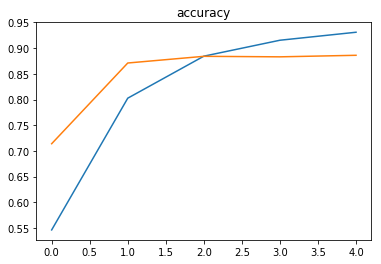

<Figure size 432x288 with 0 Axes>

In [17]:
plot_accuracy(history)

In [18]:

# with a Sequential model
get_embed_out = keras.backend.function(
    [model.layers[0].input],
    [model.layers[1].output])

In [19]:
layer_output = get_embed_out([x_val[0]])[0]

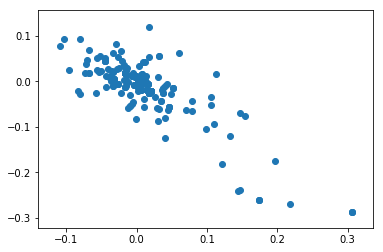

In [20]:
plt.scatter(layer_output[:,0], layer_output[:,1])

In [21]:
review = ['great', 'brilliant','crap','bad', 'tomato', 'fantastic', 'movie', 'seagal']
enc_review = [word_index[word] for word in review]
enc_review

[87, 530, 595, 78, 10373, 777, 20, 3272]

In [22]:
layer_output = get_embed_out([enc_review])[0]

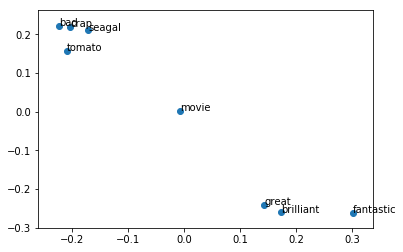

In [23]:
plt.scatter(layer_output[:,0], layer_output[:,1])
for i, txt in enumerate(review):
    plt.annotate(txt, (layer_output[i,0], layer_output[i,1]))

In [24]:
def plot_review(i):
    layer_output = get_embed_out([x_val[i]])[0]
    plt.scatter(layer_output[:,0], layer_output[:,1])
    plt.title(y_val[i])
    axes = plt.gca()
    axes.set_xlim([-0.5,0.5])
    axes.set_ylim([-0.5, 0.5])


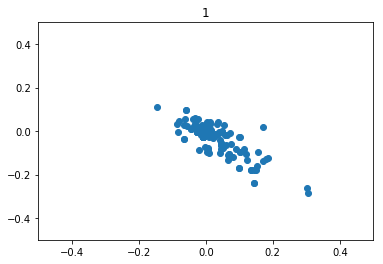

In [25]:
plot_review(16)